<a href="https://colab.research.google.com/github/abia200304/IIIT-Hyderabad-Research_works/blob/main/TCN_PEMS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -o /content/my_pems_data.zip

Archive:  /content/my_pems_data.zip
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-2024_0600.csv  
  inflating: m

In [2]:
from glob import glob
import pandas as pd
import numpy as np

file_paths = glob('/content/my_pems_data/*.csv')
all_data = []

for file in file_paths:
    try:
        df = pd.read_csv(file, delimiter='\t')
        df.columns = df.columns.str.strip()
        if 'Flow (Veh/5 Minutes)' in df.columns and 'Truck Flow (Veh/5 Minutes)' in df.columns:
            all_data.append(df[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])
        else:
            print(f"Skipping {file}: Required columns not found")
    except Exception as e:
        print(f"Error reading {file}: {e}")


In [3]:
combined_df = pd.concat(all_data, ignore_index=True)
print(combined_df.shape)

(22824, 2)


In [4]:
def process_traffic_data(df):

    processed_df = df.copy()

    processed_df = processed_df.rename(columns={
        'Flow (Veh/5 Minutes)': 'total_flow',
        'Truck Flow (Veh/5 Minutes)': 'truck_flow'
    })

    if 'total_flow' not in processed_df.columns or 'truck_flow' not in processed_df.columns:
        print("Error: Renaming of columns failed. Check original column names.")
        return None

    # Calculate Non-Truck Flow = Total Flow - Truck Flow
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']

    # Handle any negative values
    negative_mask = processed_df['non_truck_flow'] < 0
    if negative_mask.sum() > 0:
        print(f"⚠️ Warning: {negative_mask.sum()} rows have negative non-truck flow values")
        processed_df.loc[negative_mask, 'non_truck_flow'] = 0

    # Add time-based features
    processed_df['time_index'] = range(len(processed_df))

    return processed_df


In [5]:
processed_df = process_traffic_data(combined_df)


In [6]:
display(processed_df)
print(processed_df.shape)

,total_flow,truck_flow,non_truck_flow,time_index
0,14.0,0.0,14.0,0
1,30.0,0.0,30.0,1
2,25.0,0.0,25.0,2
3,15.0,0.0,15.0,3
4,16.0,0.0,16.0,4
...,...,...,...,...
22819,38.0,0.0,38.0,22819
22820,40.0,0.0,40.0,22820
22821,41.0,0.0,41.0,22821
22822,30.0,0.0,30.0,22822


(22824, 4)


In [7]:
processed_df.columns

Index(['total_flow', 'truck_flow', 'non_truck_flow', 'time_index'], dtype='object')

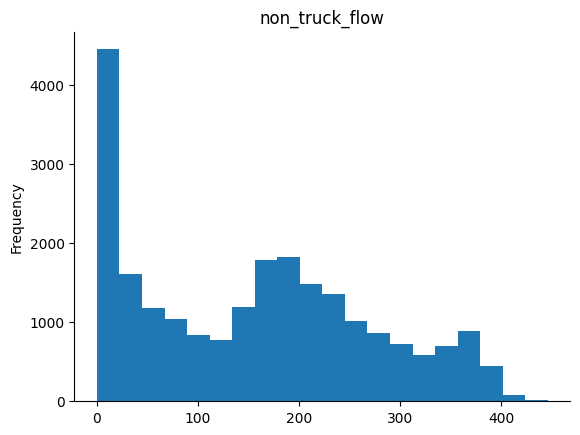

In [8]:
from matplotlib import pyplot as plt
processed_df['non_truck_flow'].plot(kind='hist', bins=20, title='non_truck_flow')
plt.gca().spines[['top', 'right',]].set_visible(False)

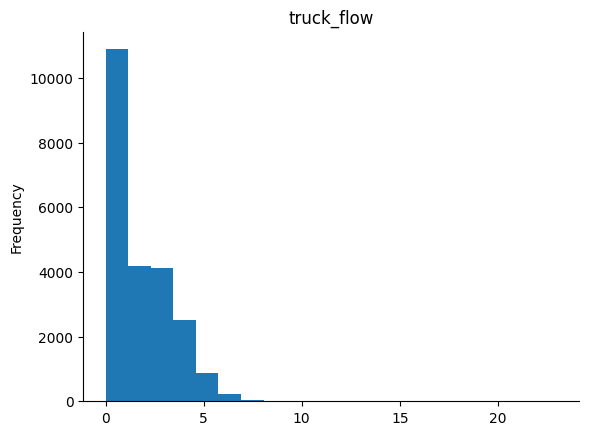

In [9]:

from matplotlib import pyplot as plt
processed_df['truck_flow'].plot(kind='hist', bins=20, title='truck_flow')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
column_1_data = processed_df['truck_flow']
column_2_data = processed_df['non_truck_flow']

In [11]:
coloumn_1_data=np.array(column_1_data)
coloumn_2_data=np.array(column_2_data)

In [12]:

column1_data=coloumn_1_data.reshape(-1,1)
column2_data =coloumn_2_data.reshape(-1,1)

In [13]:
data = pd.concat([pd.DataFrame(column1_data), pd.DataFrame(column2_data)], axis=1)
print(data.shape)

(22824, 2)


In [14]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler((0,1))
scaled_data=scalar.fit_transform(data)

In [15]:
scaled_data.shape

(22824, 2)

In [16]:
display(scaled_data)

array([[0.        , 0.03139013],
       [0.        , 0.06726457],
       [0.        , 0.05605381],
       ...,
       [0.        , 0.09192825],
       [0.        , 0.06726457],
       [0.        , 0.05829596]])

In [17]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)
time_step = 15
X, Y= create_dataset(scaled_data, time_step)
print(X.shape)
print(Y.shape)

(22809, 15, 2)
(22809, 2)


In [18]:
X_train=X[:int(0.8*len(X))]
y_train = Y[:int(0.8*len(Y))].reshape(-1,2)
X_test = X[int(0.8*len(X)):]
y_test = Y[int(0.8*len(Y)):].reshape(-1,2)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18247, 15, 2)
(18247, 2)
(4562, 15, 2)
(4562, 2)


In [20]:
!pip install keras-tcn

In [21]:
# from tensorflow.keras.layers import Input,Dense,Dropout
# from tensorflow.keras.models import Model
# from keras import regularizers
# from tcn import TCN
# inputs=Input(shape=(15,2))

# x = TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4, 8,16] )(inputs)
# xx=Dropout(0.2)(x)
# x = TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4, 8,16] )(xx)

# x=Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.001))(xx)
# outputs=Dense(2,kernel_regularizer=regularizers.l2(0.001))(x)
# model=Model(inputs=inputs,outputs=outputs)

# model.compile(optimizer='adam',loss='mae')
# model.summary()

In [22]:
from tensorflow.keras.layers import Input, Dense, Dropout, Add
from tensorflow.keras.models import Model
from keras import regularizers
from tcn import TCN

inputs = Input(shape=(15, 2))

# First TCN block
x = TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4, 8], return_sequences=True)(inputs)
xx = Dropout(0.15)(x)


tcn_out_for_residual = TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4, 8], return_sequences=True)(xx)

x = Add()([xx, tcn_out_for_residual])


from tensorflow.keras.layers import GlobalAveragePooling1D

x = GlobalAveragePooling1D()(x)

x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
outputs = Dense(2, kernel_regularizer=regularizers.l2(0.0001))(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn (TCN)           │ (None, 15, 32)    │     22,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 32)    │          0 │ tcn[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_1 (TCN)         │ (None, 15, 32)    │     24,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 32)    │          0 │ dropout[0][0],    │
│                     │                   │            │ tcn_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ add[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         34 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,442 (185.32 KB)

 Trainable params: 47,442 (185.32 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history=model.fit(X_train,y_train,epochs=50,validation_split=0.15,verbose=1)

Epoch 1/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.5460 - val_loss: 0.0053
Epoch 2/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 3/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 4/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 5/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 6/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 7/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 8/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 9/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 10/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 11/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 12/50
485/485 ━━━━━━━━━━━━━━━

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

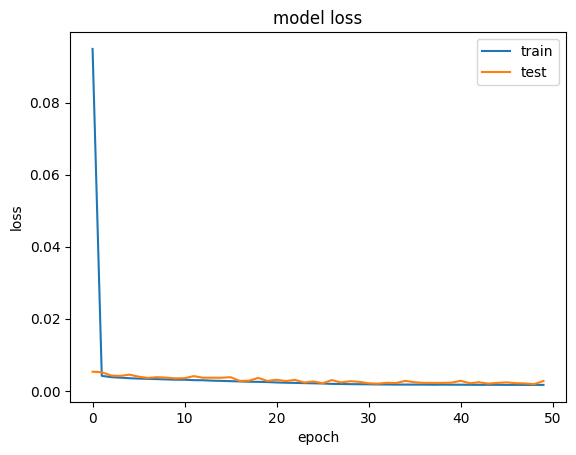

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt

In [25]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
y_pred=model.predict(X_test)
test_predict=model.predict(X_test)
print(test_predict.shape)
predictions_original_scale = scalar.inverse_transform(test_predict)
y_test_original_scale = scalar.inverse_transform(y_test)
mae=mean_absolute_error(predictions_original_scale,y_test_original_scale,)
mse=np.sqrt(mean_squared_error(predictions_original_scale,y_test_original_scale,))
mape=mean_absolute_percentage_error(predictions_original_scale,y_test_original_scale,)
rmse=np.sqrt(mse)
print(rmse)
print(mse)
print(mae)
print(mape)

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(4562, 2)
4.281049485786319
18.327384699751306
9.46936778841456
0.3750007809806526


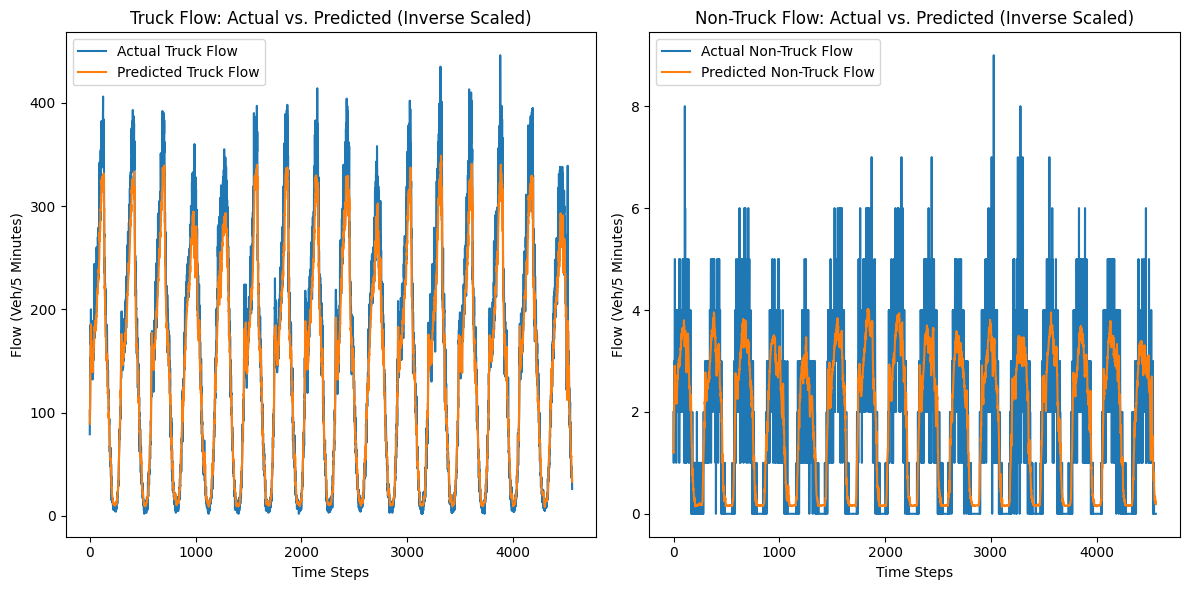

In [26]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

#  Truck Flow
plt.subplot(1, 2, 1)
plt.plot(y_test_original_scale[:, 1], label='Actual Truck Flow')
plt.plot(predictions_original_scale[:, 1], label='Predicted Truck Flow')
plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

# Non-Truck Flow
plt.subplot(1, 2, 2)
plt.plot(y_test_original_scale[:, 0] , label='Actual Non-Truck Flow')
plt.plot(predictions_original_scale[:, 0], label='Predicted Non-Truck Flow')
plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

plt.tight_layout()
plt.show()